In [1]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import STL
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.feature_selection import RFECV

In [3]:
df = pd.read_csv("../data/stage/SO2/clean/CEN-TRAF.csv")
# make date time index
df.index = pd.to_datetime(df["datetime"])
df.drop(columns=["datetime"], inplace=True)
df.head()


,target,DViento_SSR,HAire10_SSR,P_SSR,TAire10_SSR,VViento_SSR
datetime,,,,,,
2021-03-04 00:00:00,22.695646,93.976,83.636,812.138,15.485,0.316
2021-03-04 01:00:00,23.594697,98.891,85.380,811.545,15.135,0.202
2021-03-04 02:00:00,16.030704,281.536,92.472,810.995,14.066,0.112
2021-03-04 03:00:00,14.645217,222.799,90.975,810.494,14.133,0.245
2021-03-04 04:00:00,15.532171,193.713,91.169,810.758,13.872,0.532


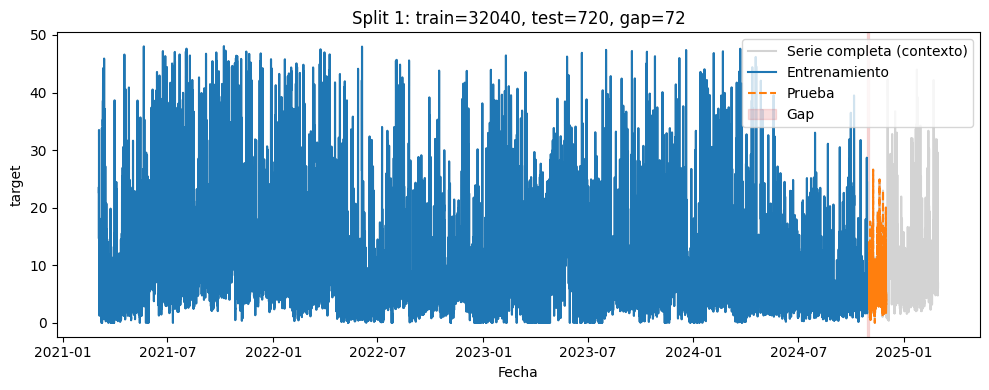

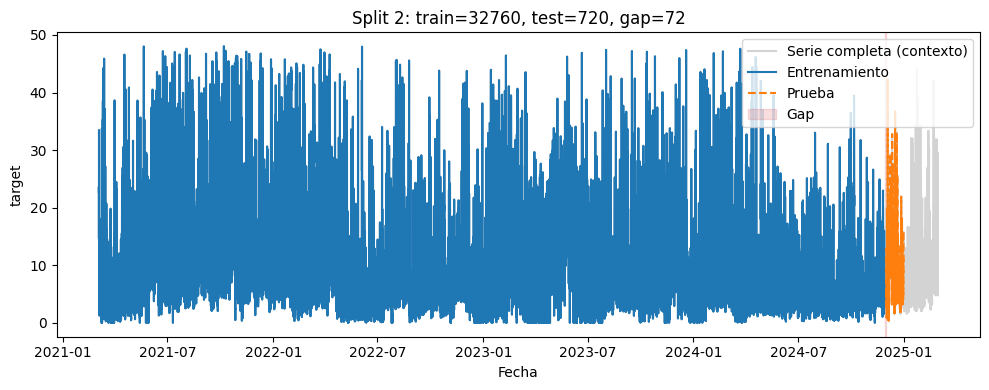

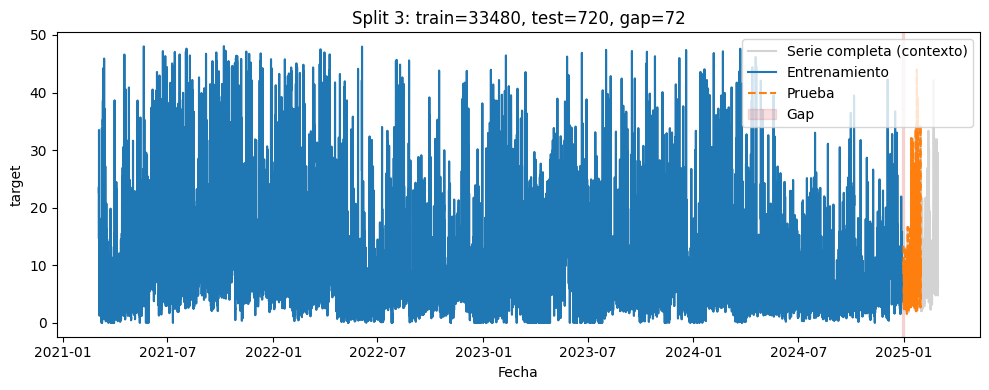

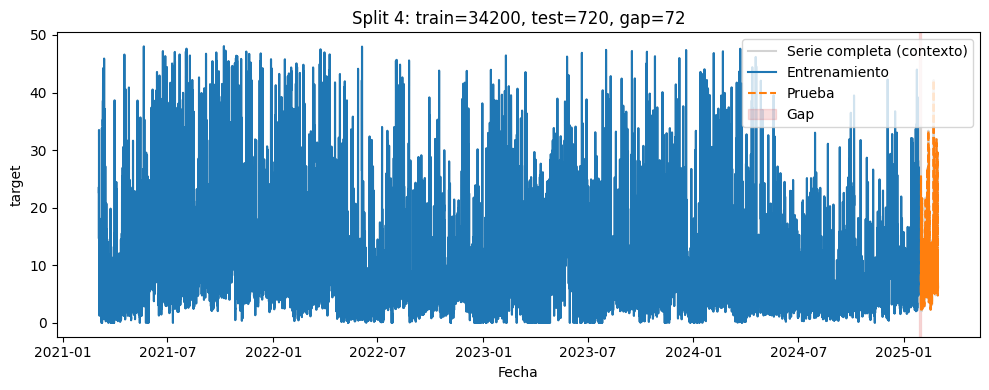

In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit

# === Configura TimeSeriesSplit ===
tscv = TimeSeriesSplit(
    n_splits=4, test_size=24 * 30, gap=72
)  # puedes cambiar test_size y gap

# === Visualización de cada split ===
for i, (train_idx, test_idx) in enumerate(tscv.split(df), start=1):
    fig, ax = plt.subplots(figsize=(10, 4))

    # Serie completa para contexto
    ax.plot(
        df.index, df["target"], color="lightgray", label="Serie completa (contexto)"
    )

    # Entrenamiento
    ax.plot(
        df.index[train_idx],
        df["target"].iloc[train_idx],
        color="tab:blue",
        label="Entrenamiento",
    )

    # Prueba
    ax.plot(
        df.index[test_idx],
        df["target"].iloc[test_idx],
        color="tab:orange",
        linestyle="--",
        label="Prueba",
    )

    # Gap
    if len(train_idx) > 0 and len(test_idx) > 0:
        gap_start = train_idx[-1] + 1
        gap_end = test_idx[0] - 1
        if gap_end >= gap_start:
            ax.axvspan(
                df.index[gap_start],
                df.index[gap_end],
                color="tab:red",
                alpha=0.15,
                label="Gap",
            )

    ax.set_title(
        f"Split {i}: train={len(train_idx)}, test={len(test_idx)}, gap={tscv.gap}"
    )
    ax.set_xlabel("Fecha")
    ax.set_ylabel("target")
    ax.legend(loc="best")
    plt.tight_layout()
    plt.show()


# Create columns

In [5]:
class DateTimeFeatures(BaseEstimator, TransformerMixin):
    def __init__(
        self, time_col="ds", country_holidays="CO", drop_time_col=False, tz=None
    ):
        self.time_col = time_col
        self.country_holidays = country_holidays
        self.drop_time_col = drop_time_col
        self.tz = tz

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        X[self.time_col] = pd.to_datetime(X[self.time_col])
        if self.tz:
            X[self.time_col] = (
                X[self.time_col]
                .dt.tz_localize(self.tz, nonexistent="shift_forward", ambiguous="NaT")
                .dt.tz_convert(self.tz)
            )

        dt = X[self.time_col]
        X["year"] = dt.dt.year
        X["month"] = dt.dt.month
        X["day"] = dt.dt.day
        X["hour"] = dt.dt.hour
        X["dow"] = dt.dt.weekday  # 0=lunes
        X["weekofyear"] = dt.dt.isocalendar().week.astype(int)
        X["is_weekend"] = (X["dow"] >= 5).astype(int)
        X["is_month_start"] = dt.dt.is_month_start.astype(int)
        X["is_month_end"] = dt.dt.is_month_end.astype(int)

        try:
            import holidays

            hol = holidays.CountryHoliday(self.country_holidays)
            X["is_holiday"] = dt.dt.date.astype("datetime64").isin(hol).astype(int)
        except Exception:
            X["is_holiday"] = 0

        if self.drop_time_col:
            X = X.drop(columns=[self.time_col])
        return X


class LagFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, target_col="y", lags=[1, 4, 8, 12]):
        self.target_col = target_col
        self.lags = list(lags)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for L in self.lags:
            X[f"{self.target_col}_lag{L}"] = X[self.target_col].shift(L)
        return X


class RollingStats(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        target_col="y",
        windows=(3, 6, 12, 24, 48, 72),
        stats=("mean", "std", "min", "max"),
    ):
        self.target_col = target_col
        self.windows = windows
        self.stats = stats

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for w in self.windows:
            roll = X[self.target_col].shift(1).rolling(w)
            if "mean" in self.stats:
                X[f"{self.target_col}_roll{w}_mean"] = roll.mean()
            if "std" in self.stats:
                X[f"{self.target_col}_roll{w}_std"] = roll.std(ddof=0)
            if "min" in self.stats:
                X[f"{self.target_col}_roll{w}_min"] = roll.min()
            if "max" in self.stats:
                X[f"{self.target_col}_roll{w}_max"] = roll.max()
        return X


class STLFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, target_col="y", period=24, robust=True, enabled=True):
        self.target_col = target_col
        self.period = period
        self.robust = robust
        self.enabled = enabled

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        if not self.enabled:
            return X
        series = X[self.target_col].astype(float)
        series_filled = series.interpolate(limit_direction="both")
        res = STL(series_filled, period=self.period, robust=self.robust).fit()
        X[f"{self.target_col}_stl_trend"] = res.trend
        X[f"{self.target_col}_stl_season"] = res.seasonal
        X[f"{self.target_col}_stl_resid"] = res.resid
        return X


def build_features_from_df(
    df, time_col_name="datetime", target_col_name="SO2", stl_period=24, use_stl=True
):
    if isinstance(df.index, pd.DatetimeIndex):
        df_ = df.copy()
        df_[time_col_name] = df_.index
    else:
        df_ = df.copy()

    pipe = Pipeline(
        steps=[
            (
                "dt",
                DateTimeFeatures(
                    time_col=time_col_name, country_holidays="CO", drop_time_col=False
                ),
            ),
            (
                "lags",
                LagFeatures(
                    target_col=target_col_name, lags=[1, 2, 3, 6, 12, 24, 48, 72]
                ),
            ),  # 72 lags
            (
                "roll",
                RollingStats(
                    target_col=target_col_name, windows=(3, 6, 12, 24, 48, 72)
                ),
            ),  # ajustable
            (
                "stl",
                STLFeatures(
                    target_col=target_col_name, period=stl_period, enabled=use_stl
                ),
            ),
        ]
    )

    feat = pipe.fit_transform(df_)

    return feat


In [6]:
df_feat = build_features_from_df(
    df, time_col_name="datetime", target_col_name="target", stl_period=168, use_stl=True
)


In [7]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34992 entries, 2021-03-04 00:00:00 to 2025-02-28 23:00:00
Data columns (total 52 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   target              34992 non-null  float64       
 1   DViento_SSR         34992 non-null  float64       
 2   HAire10_SSR         34992 non-null  float64       
 3   P_SSR               34992 non-null  float64       
 4   TAire10_SSR         34992 non-null  float64       
 5   VViento_SSR         34992 non-null  float64       
 6   datetime            34992 non-null  datetime64[ns]
 7   year                34992 non-null  int32         
 8   month               34992 non-null  int32         
 9   day                 34992 non-null  int32         
 10  hour                34992 non-null  int32         
 11  dow                 34992 non-null  int32         
 12  weekofyear          34992 non-null  int32         
 13  is_weekend 

Rangos
Train : 2021-03-04 00:00:00 → 2023-12-19 13:00:00 24494
Val   : 2023-12-19 14:00:00 → 2024-07-25 06:00:00 5249
Test  : 2024-07-25 07:00:00 → 2025-02-28 23:00:00 5249
Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejores params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'min_child_samples': 20, 'n_estimators': 400, 'num_leaves': 31, 'subsample': 0.8}
Best CV (neg MAE): -0.7204701116406574
       VAL -> MAE: 0.1846 | RMSE: 0.2619 | MAPE: 32.82%
      TEST -> MAE: 0.2345 | RMSE: 0.3617 | MAPE: 21.36%


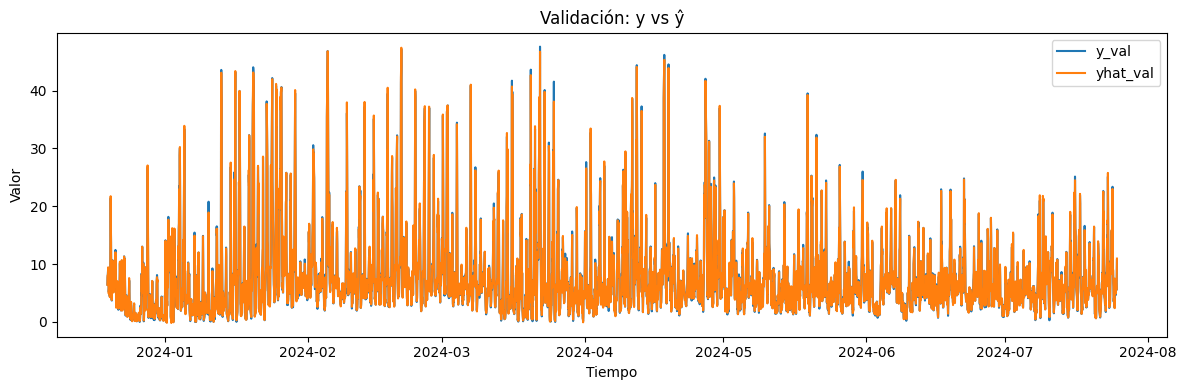

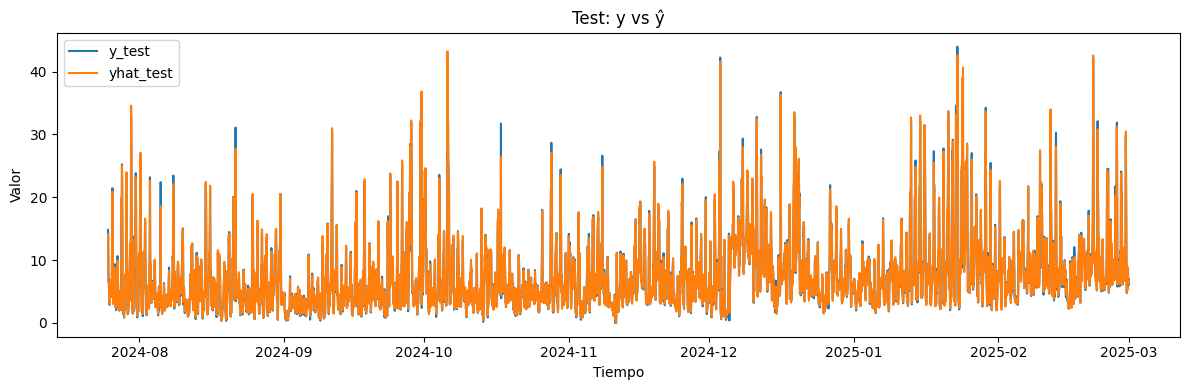

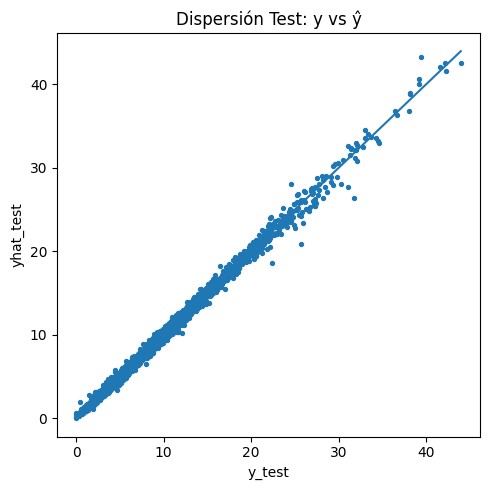

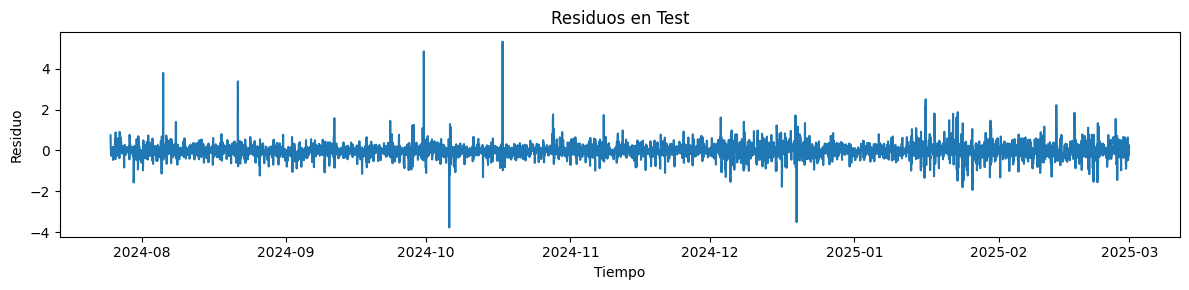

In [8]:
# =======================
# LGBM + TimeSeriesSplit + Grid pequeño + Métricas + Gráficas
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor


# --- MAPE seguro (evita divisiones por cero) ---
def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)))


# ===== 1) Preparación =====
df = df_feat.copy()  # <-- tu DataFrame
if "datetime" in df.columns:
    df = df.set_index("datetime")
df.index = pd.to_datetime(df.index)
df = df.sort_index()

target_col = "target"
feature_cols = [c for c in df.columns if c != target_col]

X = df[feature_cols]
y = df[target_col]

# ===== 2) Particiones por tiempo (70/15/15) =====
n = len(df)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test = X.iloc[val_end:], y.iloc[val_end:]

print("Rangos")
print("Train :", X_train.index.min(), "→", X_train.index.max(), len(X_train))
print("Val   :", X_val.index.min(), "→", X_val.index.max(), len(X_val))
print("Test  :", X_test.index.min(), "→", X_test.index.max(), len(X_test))

# ===== 3) GridSearchCV con TimeSeriesSplit =====
tscv = TimeSeriesSplit(n_splits=3)

param_grid = {
    "n_estimators": [200, 400],
    "learning_rate": [0.1, 0.05],
    "num_leaves": [31, 63],
    "max_depth": [-1, 10],
    "subsample": [0.8],
    "colsample_bytree": [0.8],
    "min_child_samples": [20],
}

base = LGBMRegressor(
    random_state=15926,
    objective="regression",
    verbose=-1,
)

grid = GridSearchCV(
    estimator=base,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",  # usa MAE para seleccionar
    cv=tscv,
    n_jobs=-1,
    refit=True,
    verbose=1,
)

grid.fit(X_train, y_train)
print("Mejores params:", grid.best_params_)
print("Best CV (neg MAE):", grid.best_score_)

# ===== 4) Reentrenar con TRAIN+VAL (aprovecha más datos) =====
best = grid.best_estimator_
best.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))


# ===== 5) Función de evaluación (MAE, RMSE, MAPE) =====
def eval_split(y_true, yhat, name):
    mae = mean_absolute_error(y_true, yhat)
    # Compatibilidad con cualquier versión de sklearn:
    rmse = float(np.sqrt(mean_squared_error(y_true, yhat)))
    mape = mape_safe(y_true, yhat)
    print(f"{name:>10} -> MAE: {mae:.4f} | RMSE: {rmse:.4f} | MAPE: {mape:.2%}")
    return mae, rmse, mape


# ===== 6) Evaluaciones =====
pred_val = best.predict(X_val)
pred_test = best.predict(X_test)

mae_v, rmse_v, mape_v = eval_split(y_val, pred_val, "VAL")
mae_t, rmse_t, mape_t = eval_split(y_test, pred_test, "TEST")

# ===== 7) GRÁFICAS (una por figura, sin estilos/colores forzados) =====
# a) Validación: y vs yhat
plt.figure(figsize=(12, 4))
plt.plot(y_val.index, y_val.values, label="y_val")
plt.plot(y_val.index, pred_val, label="yhat_val")
plt.title("Validación: y vs ŷ")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.tight_layout()
plt.show()

# b) Test: y vs yhat
plt.figure(figsize=(12, 4))
plt.plot(y_test.index, y_test.values, label="y_test")
plt.plot(y_test.index, pred_test, label="yhat_test")
plt.title("Test: y vs ŷ")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.tight_layout()
plt.show()

# c) Dispersión (Test)
plt.figure(figsize=(5, 5))
plt.scatter(y_test.values, pred_test, s=8)
lims = [min(y_test.min(), pred_test.min()), max(y_test.max(), pred_test.max())]
plt.plot(lims, lims)
plt.title("Dispersión Test: y vs ŷ")
plt.xlabel("y_test")
plt.ylabel("yhat_test")
plt.tight_layout()
plt.show()

# d) Residuos (Test)
resid = y_test.values - pred_test
plt.figure(figsize=(12, 3))
plt.plot(y_test.index, resid)
plt.title("Residuos en Test")
plt.xlabel("Tiempo")
plt.ylabel("Residuo")
plt.tight_layout()
plt.show()


72-step -> MAE: 3.2710 | RMSE: 3.2724 | MAPE: 22.52%


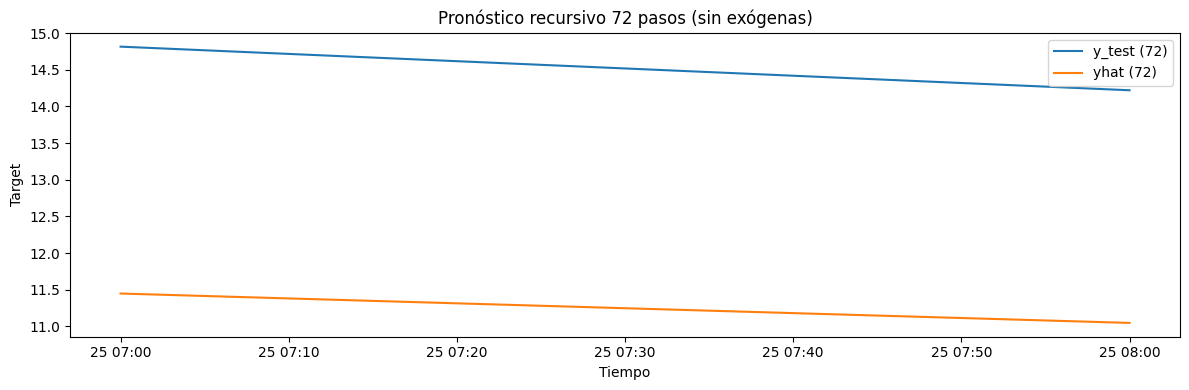

In [11]:
# =======================
# Recursivo 72 pasos con LGBM y frecuencia fija en y
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from skforecast.recursive import ForecasterRecursive
from sklearn.metrics import mean_absolute_error, mean_squared_error


# --- MAPE seguro ---
def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)))


# --- 1) Trae tu DF y prepara la serie ---
df = df_feat.copy()
if "datetime" in df.columns:
    df = df.set_index("datetime")
df.index = pd.to_datetime(df.index)
df = df.sort_index()

y = df["target"].astype(float)

# --- 2) Asegurar FRECUENCIA en el índice de y ---
# Intentamos inferir la frecuencia real (ej. 'H'). Si no, usamos 'H' por defecto.
freq_inferred = pd.infer_freq(y.index)
freq = freq_inferred if freq_inferred is not None else "H"

# Si hay huecos, resampleamos a esa frecuencia y rellenamos por interpolación temporal.
# Si NO hay huecos, esto solo fijará la freq sin cambiar valores.
y = y.resample(freq).mean()

# Relleno simple (elige lo que prefieras):
if y.isna().any():
    # Interpola en el tiempo y luego ffill/bfill por seguridad en extremos
    y = y.interpolate(method="time", limit_direction="both").ffill().bfill()

# Ahora y tiene DatetimeIndex con .freq fijo
assert isinstance(y.index, pd.DatetimeIndex)
# Nota: y.index.freq puede ser None en algunos casos tras resample antiguo,
# pero skforecast lo acepta siempre que sea un DatetimeIndex regular y sin huecos.

# --- 3) Particiones por tiempo (70/15/15) ---
n = len(y)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

y_train = y.iloc[:train_end]
y_val = y.iloc[train_end:val_end]
y_test = y.iloc[val_end:]

# Entrenamos con TRAIN+VAL para usar toda la info anterior al test
y_trainval = pd.concat([y_train, y_val])

# --- 4) Forecaster recursivo LGBM ---
forecaster = ForecasterRecursive(
    regressor=LGBMRegressor(
        random_state=15926,
        objective="regression",
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=63,
        max_depth=10,
        verbose=-1,
    ),
    lags=[1, 2, 4, 8, 12],  # ajusta lags según lo que te funcionó mejor
)

# Fit sin exógenas
forecaster.fit(y=y_trainval)

# --- 5) Predicción a 72 pasos ---
steps = 2
pred_72 = forecaster.predict(steps=steps)

# Alinear contra el inicio de TEST
y_test_72 = y_test.iloc[: len(pred_72)]

# --- 6) Métricas ---
mae_72 = mean_absolute_error(y_test_72, pred_72)
rmse_72 = float(np.sqrt(mean_squared_error(y_test_72, pred_72)))
mape_72 = mape_safe(y_test_72, pred_72)
print(f"72-step -> MAE: {mae_72:.4f} | RMSE: {rmse_72:.4f} | MAPE: {mape_72:.2%}")

# --- 7) Plot 72h ---
plt.figure(figsize=(12, 4))
plt.plot(y_test_72.index, y_test_72.values, label="y_test (72)")
plt.plot(pred_72.index, pred_72.values, label="yhat (72)")
plt.title("Pronóstico recursivo 72 pasos (sin exógenas)")
plt.xlabel("Tiempo")
plt.ylabel("Target")
plt.legend()
plt.tight_layout()
plt.show()


[Direct] 72 pasos -> MAE: 2.1839 | RMSE: 2.2414 | MAPE: 14.98%
   h       MAE      RMSE      MAPE
0  1  2.688440  2.688440  0.181450
1  2  1.679389  1.679389  0.118089


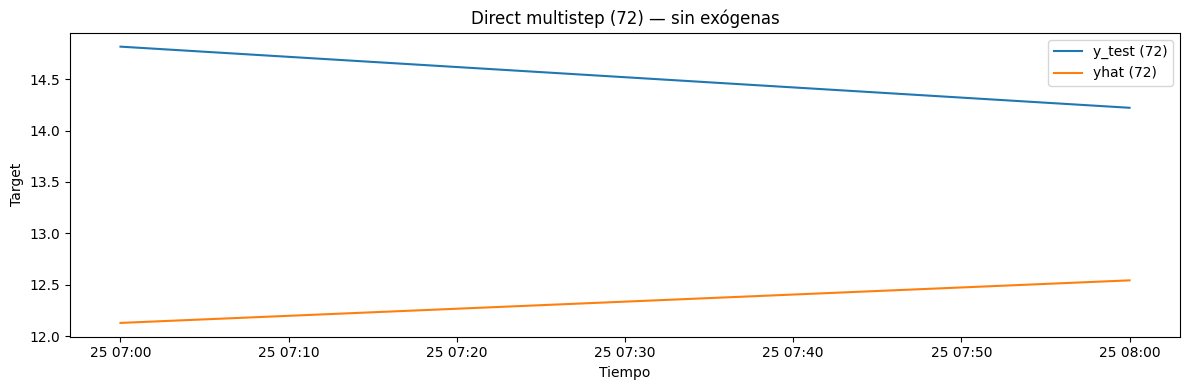

In [10]:
# =======================
# Direct multistep (72) con LGBM (sin exógenas)
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from skforecast.direct import ForecasterDirect
from sklearn.metrics import mean_absolute_error, mean_squared_error


# --- MAPE seguro ---
def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)))


def rmse_safe(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


# ===== 1) Preparar serie =====
df = df_feat.copy()  # <-- tu DF con 'target'
if "datetime" in df.columns:
    df = df.set_index("datetime")
df.index = pd.to_datetime(df.index)
df = df.sort_index()

y = df["target"].astype(float)

# Asegurar frecuencia explícita (requerido por skforecast)
freq_inferred = pd.infer_freq(y.index)
freq = freq_inferred if freq_inferred is not None else "H"
y = y.resample(freq).mean()
if y.isna().any():
    y = y.interpolate(method="time", limit_direction="both").ffill().bfill()

# ===== 2) Splits por tiempo (70/15/15) =====
n = len(y)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

y_train = y.iloc[:train_end]
y_val = y.iloc[train_end:val_end]
y_test = y.iloc[val_end:]

# Entrenar con TRAIN+VAL para predecir el comienzo de TEST
y_trainval = pd.concat([y_train, y_val])

# ===== 3) ForecasterDirect (72 modelos, uno por horizonte) =====
steps_h = 2
forecaster = ForecasterDirect(
    regressor=LGBMRegressor(
        random_state=15926,
        objective="regression",
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=63,
        max_depth=10,
        verbose=-1,
    ),
    lags=[1, 2, 8, 12, 24],  # ajusta a tu caso
    steps=steps_h,
)

forecaster.fit(y=y_trainval)

# ===== 4) Predicción 72 pasos hacia adelante =====
pred_72 = forecaster.predict(steps=steps_h)  # devuelve Serie/DF con 72 pasos
# Alinea contra las primeras 72 de test
y_test_72 = y_test.iloc[: len(pred_72)]

# ===== 5) Métricas globales (sobre el bloque 72h) =====
mae_72 = mean_absolute_error(y_test_72, pred_72)
rmse_72 = rmse_safe(y_test_72, pred_72)
mape_72 = mape_safe(y_test_72, pred_72)
print(
    f"[Direct] 72 pasos -> MAE: {mae_72:.4f} | RMSE: {rmse_72:.4f} | MAPE: {mape_72:.2%}"
)

# ===== 6) Métricas por horizonte h (1..72) =====
# ForecasterDirect devuelve una Serie con índice temporal (o RangeIndex) de los 72 puntos.
# Para métricas por horizonte, mapeamos cada punto a su "offset" h desde el inicio de test.
per_h = []
for h in range(steps_h):
    if h < len(y_test_72):
        y_true_h = y_test_72.iloc[h]
        y_pred_h = pred_72.iloc[h]
        per_h.append(
            {
                "h": h + 1,
                "MAE": float(np.abs(y_true_h - y_pred_h)),
                "RMSE": float(np.sqrt((y_true_h - y_pred_h) ** 2)),
                "MAPE": float(mape_safe([y_true_h], [y_pred_h])),
            }
        )
per_h_df = pd.DataFrame(per_h)
print(per_h_df.head())

# ===== 7) Gráfica del bloque 72h =====
plt.figure(figsize=(12, 4))
plt.plot(y_test_72.index, y_test_72.values, label="y_test (72)")
plt.plot(y_test_72.index, pred_72.values, label="yhat (72)")
plt.title("Direct multistep (72) — sin exógenas")
plt.xlabel("Tiempo")
plt.ylabel("Target")
plt.legend()
plt.tight_layout()
plt.show()


In [36]:
per_h_df.head(20)


,h,MAE,RMSE,MAPE
0,1,0.788022,0.788022,0.185980
1,2,1.199267,1.199267,0.279699
2,3,0.837893,0.837893,0.177204
3,4,1.315419,1.315419,0.254477
4,5,2.365553,2.365553,0.421681
5,6,5.881721,5.881721,1.399404
6,7,1.163784,1.163784,0.146039
7,8,1.057583,1.057583,0.114810
8,9,0.282810,0.282810,0.032008
9,10,0.643687,0.643687,0.080927


[Validación] 72 pasos -> MAE: 2.4302 | RMSE: 2.4415 | MAPE: 34.20%
[Test] 72 pasos -> MAE: 1.0242 | RMSE: 1.0661 | MAPE: 7.02%


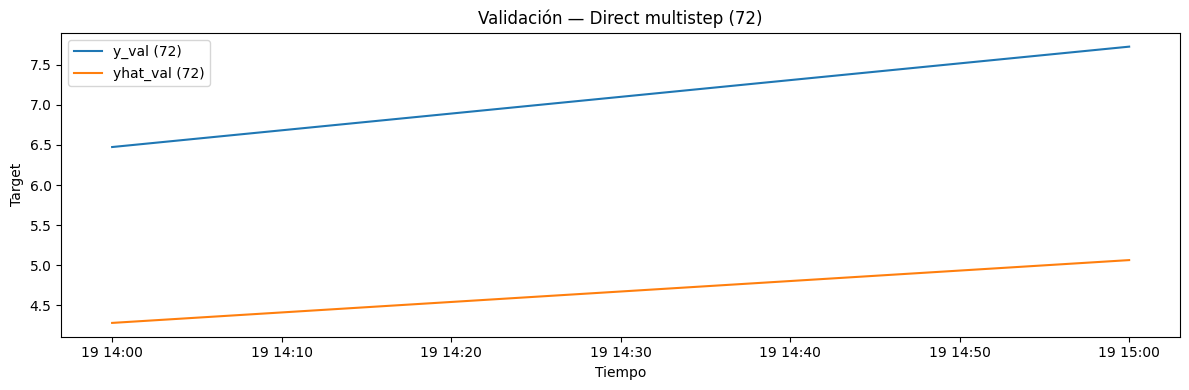

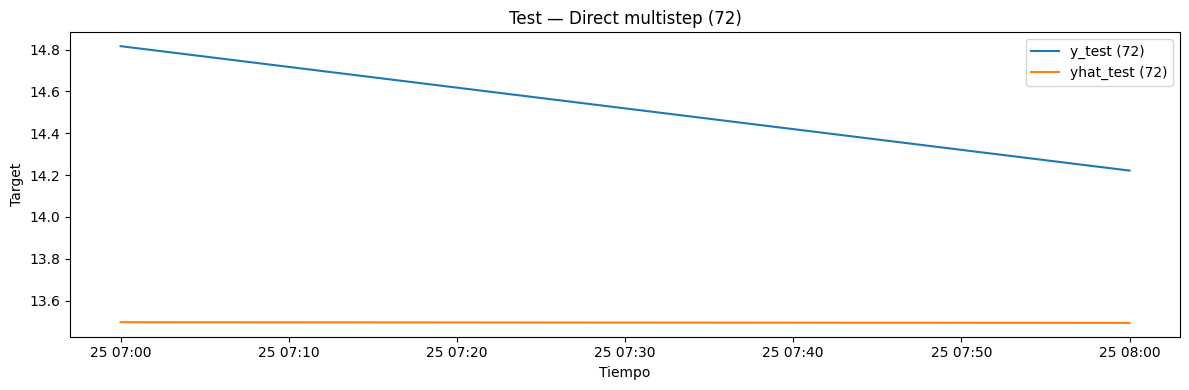

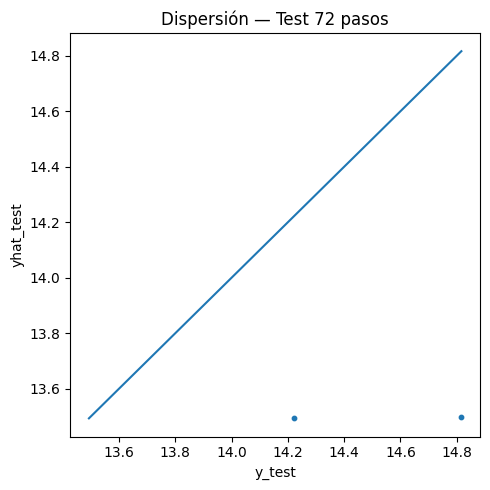

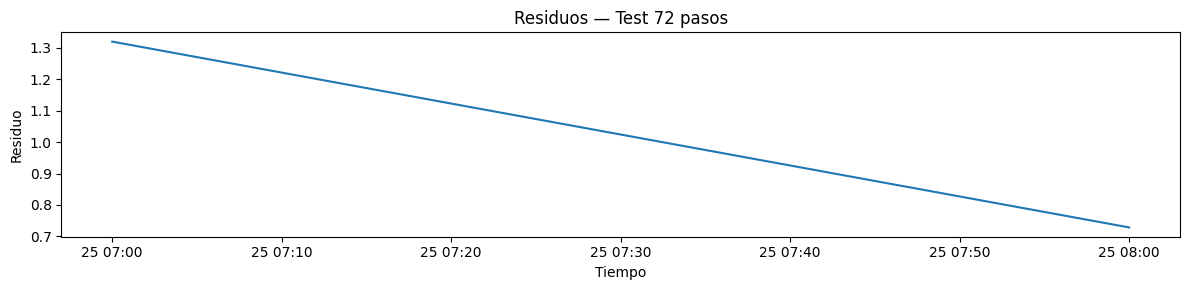

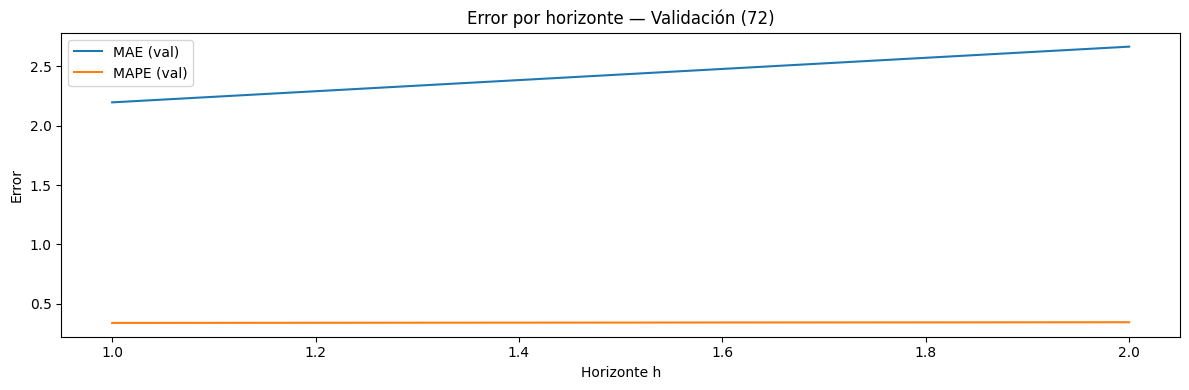

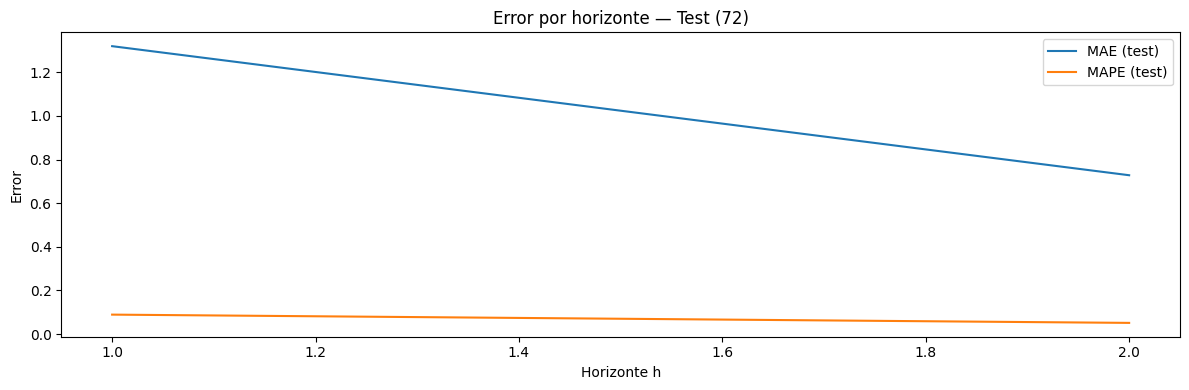


Per-horizonte (Validación) — primeras filas
    h       MAE      RMSE      MAPE
0  1  2.195641  2.195641  0.339141
1  2  2.664760  2.664760  0.344847

Per-horizonte (Test) — primeras filas
    h       MAE      RMSE      MAPE
0  1  1.320118  1.320118  0.089098
1  2  0.728282  0.728282  0.051210


In [13]:
# =======================
# Direct multistep (72) con LGBM + métricas por horizonte + gráficas (val y test)
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from skforecast.direct import ForecasterDirect
from sklearn.metrics import mean_absolute_error, mean_squared_error


# --- MAPE y RMSE seguros ---
def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)))


def rmse_safe(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


# ===== 1) Preparar serie =====
df = df_feat.copy()  # <-- tu DF con 'target'
if "datetime" in df.columns:
    df = df.set_index("datetime")
df.index = pd.to_datetime(df.index)
df = df.sort_index()

y = df["target"].astype(float)

# Asegurar frecuencia explícita (requerido por skforecast)
freq_inferred = pd.infer_freq(y.index)
freq = freq_inferred if freq_inferred is not None else "H"
y = y.resample(freq).mean()
if y.isna().any():
    y = y.interpolate(method="time", limit_direction="both").ffill().bfill()

# ===== 2) Splits por tiempo (70/15/15) =====
n = len(y)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

y_train = y.iloc[:train_end]
y_val = y.iloc[train_end:val_end]
y_test = y.iloc[val_end:]
y_trainval = pd.concat([y_train, y_val])

# ===== 3) ForecasterDirect =====
steps_h = 2
forecaster = ForecasterDirect(
    regressor=LGBMRegressor(
        random_state=15926,
        objective="regression",
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=63,
        max_depth=10,
        verbose=-1,
    ),
    lags=[1, 2, 3, 24],  # ajusta a tu caso
    steps=steps_h,
)

# =======================
# VALIDACIÓN (72 pasos)
# =======================
forecaster.fit(y=y_train)
pred_val_72 = forecaster.predict(steps=steps_h)  # Serie de 72 puntos
y_val_72 = y_val.iloc[: len(pred_val_72)]

# Métricas globales validación
mae_v = mean_absolute_error(y_val_72, pred_val_72)
rmse_v = rmse_safe(y_val_72, pred_val_72)
mape_v = mape_safe(y_val_72, pred_val_72)
print(
    f"[Validación] 72 pasos -> MAE: {mae_v:.4f} | RMSE: {rmse_v:.4f} | MAPE: {mape_v:.2%}"
)

# Métricas por horizonte en validación
per_h_val = []
for h in range(len(y_val_72)):
    yt = y_val_72.iloc[h]
    yp = pred_val_72.iloc[h]
    per_h_val.append(
        {
            "h": h + 1,
            "MAE": float(np.abs(yt - yp)),
            "RMSE": float(np.sqrt((yt - yp) ** 2)),
            "MAPE": float(mape_safe([yt], [yp])),
        }
    )
per_h_val = pd.DataFrame(per_h_val)

# =======================
# TEST (72 pasos)
# =======================
forecaster.fit(y=y_trainval)
pred_test_72 = forecaster.predict(steps=steps_h)
y_test_72 = y_test.iloc[: len(pred_test_72)]

# Métricas globales test
mae_t = mean_absolute_error(y_test_72, pred_test_72)
rmse_t = rmse_safe(y_test_72, pred_test_72)
mape_t = mape_safe(y_test_72, pred_test_72)
print(f"[Test] 72 pasos -> MAE: {mae_t:.4f} | RMSE: {rmse_t:.4f} | MAPE: {mape_t:.2%}")

# Métricas por horizonte en test
per_h_test = []
for h in range(len(y_test_72)):
    yt = y_test_72.iloc[h]
    yp = pred_test_72.iloc[h]
    per_h_test.append(
        {
            "h": h + 1,
            "MAE": float(np.abs(yt - yp)),
            "RMSE": float(np.sqrt((yt - yp) ** 2)),
            "MAPE": float(mape_safe([yt], [yp])),
        }
    )
per_h_test = pd.DataFrame(per_h_test)

# ============ GRÁFICAS ============
# 1) Validación: y vs yhat
plt.figure(figsize=(12, 4))
plt.plot(y_val_72.index, y_val_72.values, label="y_val (72)")
plt.plot(y_val_72.index, pred_val_72.values, label="yhat_val (72)")
plt.title("Validación — Direct multistep (72)")
plt.xlabel("Tiempo")
plt.ylabel("Target")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Test: y vs yhat
plt.figure(figsize=(12, 4))
plt.plot(y_test_72.index, y_test_72.values, label="y_test (72)")
plt.plot(y_test_72.index, pred_test_72.values, label="yhat_test (72)")
plt.title("Test — Direct multistep (72)")
plt.xlabel("Tiempo")
plt.ylabel("Target")
plt.legend()
plt.tight_layout()
plt.show()

# 3) Dispersión (Test)
plt.figure(figsize=(5, 5))
plt.scatter(y_test_72.values, pred_test_72.values, s=10)
lims = [
    min(y_test_72.min(), pred_test_72.min()),
    max(y_test_72.max(), pred_test_72.max()),
]
plt.plot(lims, lims)
plt.title("Dispersión — Test 72 pasos")
plt.xlabel("y_test")
plt.ylabel("yhat_test")
plt.tight_layout()
plt.show()

# 4) Residuos (Test)
resid = y_test_72.values - pred_test_72.values
plt.figure(figsize=(12, 3))
plt.plot(y_test_72.index, resid)
plt.title("Residuos — Test 72 pasos")
plt.xlabel("Tiempo")
plt.ylabel("Residuo")
plt.tight_layout()
plt.show()

# 5) Error por horizonte (Validación): MAE y MAPE
plt.figure(figsize=(12, 4))
plt.plot(per_h_val["h"], per_h_val["MAE"], label="MAE (val)")
plt.plot(per_h_val["h"], per_h_val["MAPE"], label="MAPE (val)")
plt.title("Error por horizonte — Validación (72)")
plt.xlabel("Horizonte h")
plt.ylabel("Error")
plt.legend()
plt.tight_layout()
plt.show()

# 6) Error por horizonte (Test): MAE y MAPE
plt.figure(figsize=(12, 4))
plt.plot(per_h_test["h"], per_h_test["MAE"], label="MAE (test)")
plt.plot(per_h_test["h"], per_h_test["MAPE"], label="MAPE (test)")
plt.title("Error por horizonte — Test (72)")
plt.xlabel("Horizonte h")
plt.ylabel("Error")
plt.legend()
plt.tight_layout()
plt.show()

# (Opcional) Si quieres ver las primeras filas de las tablas por horizonte:
print("\nPer-horizonte (Validación) — primeras filas\n", per_h_val.head())
print("\nPer-horizonte (Test) — primeras filas\n", per_h_test.head())


[Validación] 72 pasos (LOCF) -> MAE: 3.4431 | RMSE: 5.0477 | MAPE: 35.66%
[Test] 72 pasos (LOCF) -> MAE: 4.2992 | RMSE: 7.6521 | MAPE: 39.23%


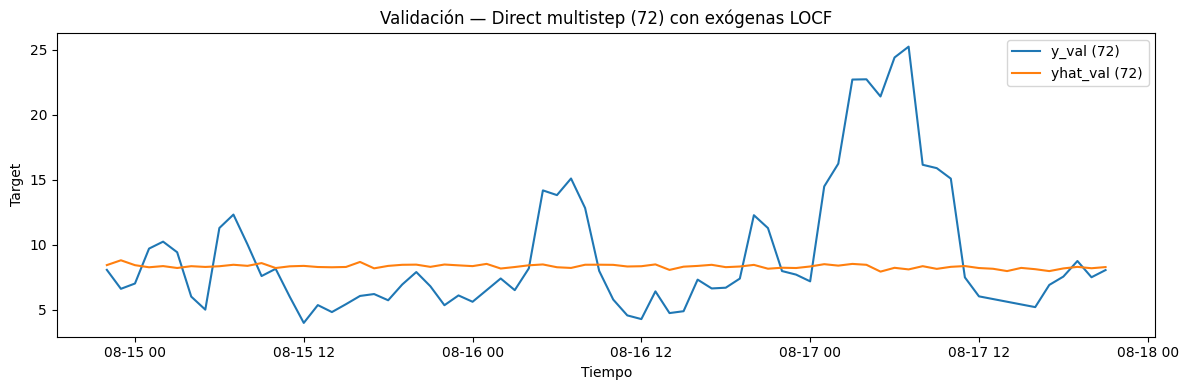

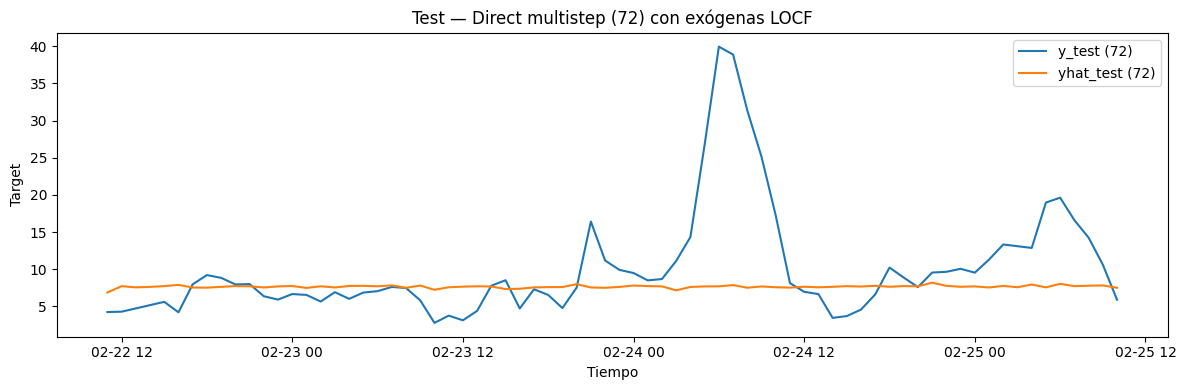

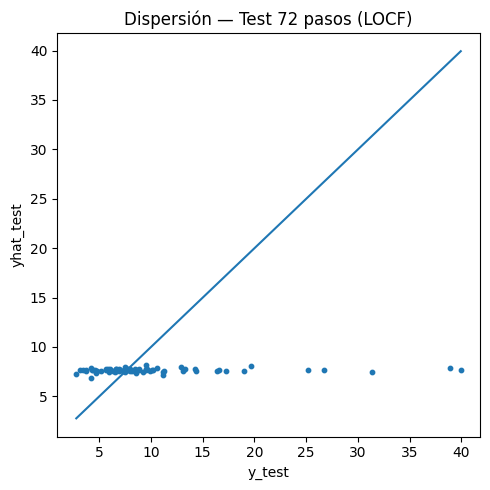

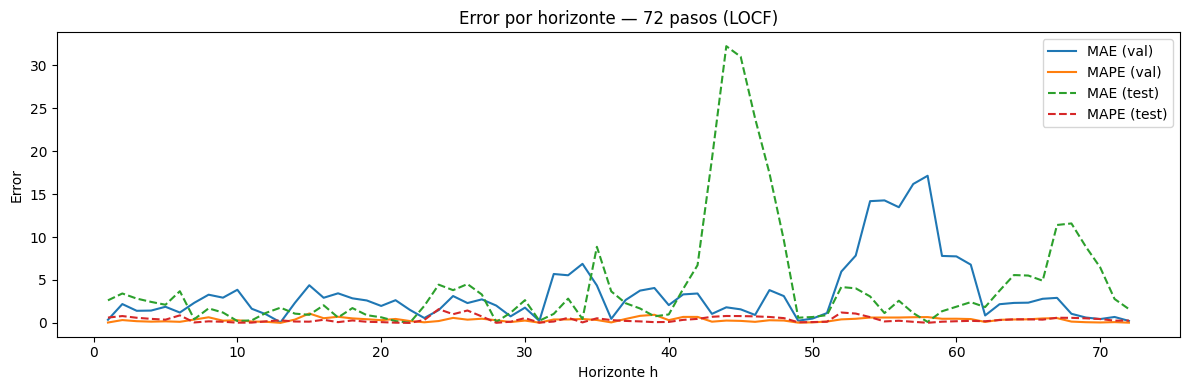


Per-horizonte (Validación) — primeras filas
    h       MAE      RMSE      MAPE
0  1  0.364706  0.364706  0.045140
1  2  2.195637  2.195637  0.331685
2  3  1.411006  1.411006  0.200783
3  4  1.437402  1.437402  0.147966
4  5  1.880970  1.880970  0.183529

Per-horizonte (Test) — primeras filas
    h       MAE      RMSE      MAPE
0  1  2.630562  2.630562  0.620834
1  2  3.427783  3.427783  0.799445
2  3  2.835238  2.835238  0.599618
3  4  2.448880  2.448880  0.473752
4  5  2.116192  2.116192  0.377230


In [40]:
# =======================
# Direct multistep (72) con LGBM
# Exógenas por LOCF (carry-forward del último valor conocido)
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lightgbm import LGBMRegressor
from skforecast.direct import ForecasterDirect
from sklearn.metrics import mean_absolute_error, mean_squared_error


# --- métricas seguras ---
def mape_safe(y_true, y_pred, eps=1e-8):
    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)
    denom = np.maximum(np.abs(y_true), eps)
    return float(np.mean(np.abs((y_true - y_pred) / denom)))


def rmse_safe(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))


# --- helper: construir exógenas futuras (LOCF) ---
def make_future_exog_locf(
    last_row: pd.Series, start_ts, periods: int, freq: str, columns_order
):
    """Crea un DataFrame futuro de exógenas (periods filas) repitiendo el último valor conocido (LOCF).
    columns_order asegura el mismo orden de columnas que en el fit."""
    idx = pd.date_range(start=start_ts, periods=periods, freq=freq)
    # last_row[columns_order] para garantizar orden idéntico
    base = last_row[columns_order]
    exog_future = pd.DataFrame(
        np.tile(base.values, (periods, 1)), index=idx, columns=columns_order
    )
    return exog_future


# ===== 1) Preparación =====
df = df_feat.copy()  # <-- tu DF con 'target' + exógenas
if "datetime" in df.columns:
    df = df.set_index("datetime")
df.index = pd.to_datetime(df.index)
df = df.sort_index()

y_all = df["target"].astype(float)
X_all = df.drop(columns=["target"], errors="ignore")

# Asegurar frecuencia explícita y rellenar pequeños huecos (requerido por skforecast)
freq_inferred = pd.infer_freq(y_all.index)
freq = freq_inferred if freq_inferred is not None else "H"

y_all = y_all.resample(freq).mean()
X_all = X_all.resample(freq).mean()

# Imputación simple para huecos
y_all = y_all.interpolate(method="time", limit_direction="both").ffill().bfill()
X_all = X_all.interpolate(method="time", limit_direction="both").ffill().bfill()

# ===== 2) Splits 70/15/15 =====
n = len(y_all)
train_end = int(n * 0.70)
val_end = int(n * 0.85)

y_train = y_all.iloc[:train_end]
y_val = y_all.iloc[train_end:val_end]
y_test = y_all.iloc[val_end:]

X_train = X_all.iloc[:train_end]
X_val = X_all.iloc[train_end:val_end]
X_test = X_all.iloc[val_end:]

y_trainval = pd.concat([y_train, y_val])
X_trainval = pd.concat([X_train, X_val])

# ===== 3) ForecasterDirect (sin exógenas con lags; solo lags del target internos) =====
steps_h = 72
forecaster = ForecasterDirect(
    regressor=LGBMRegressor(
        random_state=15926,
        objective="regression",
        n_estimators=400,
        learning_rate=0.05,
        num_leaves=63,
        max_depth=10,
        verbose=-1,
    ),
    lags=[1, 2, 3, 24],  # lags del target (internos del forecaster)
    steps=steps_h,
)

# =======================
# VALIDACIÓN (72 pasos) usando exógenas LOCF del final de TRAIN
# =======================
forecaster.fit(y=y_train, exog=X_train)

# último timestamp conocido y su exógena
last_ts_train = y_train.index[-1]
last_exog_train = X_train.iloc[-1]
# construir exógenas futuras constantes para 72 pasos
start_val = last_ts_train + pd.tseries.frequencies.to_offset(freq)
exog_val_locf_72 = make_future_exog_locf(
    last_row=last_exog_train,
    start_ts=start_val,
    periods=steps_h,
    freq=freq,
    columns_order=X_all.columns,
)

pred_val_72 = forecaster.predict(steps=steps_h, exog=exog_val_locf_72)
y_val_72 = y_val.iloc[: len(pred_val_72)]

mae_v = mean_absolute_error(y_val_72, pred_val_72)
rmse_v = rmse_safe(y_val_72, pred_val_72)
mape_v = mape_safe(y_val_72, pred_val_72)
print(
    f"[Validación] 72 pasos (LOCF) -> MAE: {mae_v:.4f} | RMSE: {rmse_v:.4f} | MAPE: {mape_v:.2%}"
)

# =======================
# TEST (72 pasos) usando exógenas LOCF del final de TRAIN+VAL
# =======================
forecaster.fit(y=y_trainval, exog=X_trainval)

last_ts_trainval = y_trainval.index[-1]
last_exog_trainval = X_trainval.iloc[-1]

start_test = last_ts_trainval + pd.tseries.frequencies.to_offset(freq)
exog_test_locf_72 = make_future_exog_locf(
    last_row=last_exog_trainval,
    start_ts=start_test,
    periods=steps_h,
    freq=freq,
    columns_order=X_all.columns,
)

pred_test_72 = forecaster.predict(steps=steps_h, exog=exog_test_locf_72)
y_test_72 = y_test.iloc[: len(pred_test_72)]

mae_t = mean_absolute_error(y_test_72, pred_test_72)
rmse_t = rmse_safe(y_test_72, pred_test_72)
mape_t = mape_safe(y_test_72, pred_test_72)
print(
    f"[Test] 72 pasos (LOCF) -> MAE: {mae_t:.4f} | RMSE: {rmse_t:.4f} | MAPE: {mape_t:.2%}"
)


# ===== 4) Métricas por horizonte =====
def per_h_metrics(y_true, y_pred):
    rows = []
    for h in range(len(y_pred)):
        yt, yp = y_true.iloc[h], y_pred.iloc[h]
        rows.append(
            {
                "h": h + 1,
                "MAE": float(np.abs(yt - yp)),
                "RMSE": float(np.sqrt((yt - yp) ** 2)),
                "MAPE": float(mape_safe([yt], [yp])),
            }
        )
    return pd.DataFrame(rows)


per_h_val = per_h_metrics(y_val_72, pred_val_72)
per_h_test = per_h_metrics(y_test_72, pred_test_72)

# ===== 5) GRÁFICAS =====
# a) Validación: y vs yhat
plt.figure(figsize=(12, 4))
plt.plot(y_val_72.index, y_val_72.values, label="y_val (72)")
plt.plot(y_val_72.index, pred_val_72.values, label="yhat_val (72)")
plt.title("Validación — Direct multistep (72) con exógenas LOCF")
plt.xlabel("Tiempo")
plt.ylabel("Target")
plt.legend()
plt.tight_layout()
plt.show()

# b) Test: y vs yhat
plt.figure(figsize=(12, 4))
plt.plot(y_test_72.index, y_test_72.values, label="y_test (72)")
plt.plot(y_test_72.index, pred_test_72.values, label="yhat_test (72)")
plt.title("Test — Direct multistep (72) con exógenas LOCF")
plt.xlabel("Tiempo")
plt.ylabel("Target")
plt.legend()
plt.tight_layout()
plt.show()

# c) Dispersión (Test)
plt.figure(figsize=(5, 5))
plt.scatter(y_test_72.values, pred_test_72.values, s=10)
lims = [
    min(y_test_72.min(), pred_test_72.min()),
    max(y_test_72.max(), pred_test_72.max()),
]
plt.plot(lims, lims)
plt.title("Dispersión — Test 72 pasos (LOCF)")
plt.xlabel("y_test")
plt.ylabel("yhat_test")
plt.tight_layout()
plt.show()

# d) Error por horizonte — Validación y Test
plt.figure(figsize=(12, 4))
plt.plot(per_h_val["h"], per_h_val["MAE"], label="MAE (val)")
plt.plot(per_h_val["h"], per_h_val["MAPE"], label="MAPE (val)")
plt.plot(per_h_test["h"], per_h_test["MAE"], label="MAE (test)", linestyle="--")
plt.plot(per_h_test["h"], per_h_test["MAPE"], label="MAPE (test)", linestyle="--")
plt.title("Error por horizonte — 72 pasos (LOCF)")
plt.xlabel("Horizonte h")
plt.ylabel("Error")
plt.legend()
plt.tight_layout()
plt.show()

print("\nPer-horizonte (Validación) — primeras filas\n", per_h_val.head())
print("\nPer-horizonte (Test) — primeras filas\n", per_h_test.head())
